In [1]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla

def tvd_mm(y, lam, Nit):
    """
    Total variation denoising using majorization-minimization
    and fast solver for banded linear systems.

    Parameters:
    y : ndarray
        Noisy signal (1D array)
    lam : float
        Regularization parameter
    Nit : int
        Number of iterations

    Returns:
    x : ndarray
        Denoised signal
    cost : list
        Cost function history
    """
    y = y.flatten()  # Ensure column vector
    cost = np.zeros(Nit)  # Cost function history
    N = len(y)

    I = sp.eye(N, format='csr')
    D = I[1:N, :] - I[0:N-1, :]
    DDT = D @ D.T

    x = y.copy()  # Initialization
    Dx = D @ x
    Dy = D @ y

    for k in range(Nit):
        F = sp.diags(np.abs(Dx) / lam) + DDT  # Sparse banded matrix
        x = y - D.T @ spla.spsolve(F, Dy)  # Solve sparse linear system
        Dx = D @ x

        cost[k] = 0.5 * np.sum(np.abs(x - y) ** 2) + lam * np.sum(np.abs(Dx))  # Save cost function history

    return x, cost


In [2]:
def EWT_beta(x):
    """
    Function used in the construction of Meyer's wavelet.

    Parameters:
    x : float
        Input value

    Returns:
    bm : float
        Output value based on the given condition
    """
    if x < 0:
        return 0
    elif x > 1:
        return 1
    else:
        return x**4 * (35 - 84*x + 70*x**2 - 20*x**3)


In [3]:
def EWT_Meyer_Scaling(w1, gamma, N):
    """
    Computes the Meyer scaling function in the EWT framework.

    Parameters:
    w1 : float
        Scaling frequency parameter
    gamma : float
        Bandwidth parameter
    N : int
        Number of points

    Returns:
    yms : ndarray
        Meyer scaling function values
    """
    Mi = N // 2
    w = np.fft.fftshift(np.linspace(0, 2*np.pi, N, endpoint=False))
    w[:Mi] -= 2 * np.pi

    aw = np.abs(w)
    yms = np.zeros(N)

    an = 1 / (2 * gamma * w1)
    pbn = (1 + gamma) * w1
    mbn = (1 - gamma) * w1

    for k in range(N):
        if aw[k] <= mbn:
            yms[k] = 1
        elif mbn < aw[k] <= pbn:
            yms[k] = np.cos(np.pi * EWT_beta(an * (aw[k] - mbn)) / 2)

    return np.fft.ifftshift(yms)


In [4]:
def EWT_Meyer_Wavelet(wn, wm, gamma, N):
    """
    Computes the Meyer wavelet function in the EWT framework.

    Parameters:
    wn : float
        Lower frequency bound
    wm : float
        Upper frequency bound
    gamma : float
        Bandwidth parameter
    N : int
        Number of points

    Returns:
    ymw : ndarray
        Meyer wavelet function values
    """
    Mi = N // 2
    w = np.fft.fftshift(np.linspace(0, 2 * np.pi, N, endpoint=False))
    w[:Mi] -= 2 * np.pi

    aw = np.abs(w)
    ymw = np.zeros(N)

    an = 1 / (2 * gamma * wn)
    am = 1 / (2 * gamma * wm)
    pbn = (1 + gamma) * wn
    mbn = (1 - gamma) * wn
    pbm = (1 + gamma) * wm
    mbm = (1 - gamma) * wm

    for k in range(N):
        if pbn <= aw[k] <= mbm:
            ymw[k] = 1
        elif mbm <= aw[k] <= pbm:
            ymw[k] = np.cos(np.pi * EWT_beta(am * (aw[k] - mbm)) / 2)
        elif mbn <= aw[k] <= pbn:
            ymw[k] = np.sin(np.pi * EWT_beta(an * (aw[k] - mbn)) / 2)

    return np.fft.ifftshift(ymw)

In [6]:
def EWT_Meyer_FilterBank(boundaries, N):
    Npic = len(boundaries)
    gamma = 1

    for k in range(Npic - 1):
        r = (boundaries[k + 1] - boundaries[k]) / (boundaries[k + 1] + boundaries[k])
        if r < gamma:
            gamma = r

    r = (np.pi - boundaries[Npic - 1]) / (np.pi + boundaries[Npic - 1])
    if r < gamma:
        gamma = r

    gamma = (1 - 1 / N) * gamma

    mfb = [None] * (Npic + 1)
    mfb[0] = EWT_Meyer_Scaling(boundaries[0], gamma, N)

    for k in range(1, Npic):
        mfb[k] = EWT_Meyer_Wavelet(boundaries[k - 1], boundaries[k], gamma, N)

    mfb[Npic] = EWT_Meyer_Wavelet(boundaries[Npic - 1], np.pi, gamma, N)

    return mfb

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def Show_EWT_Boundaries(magf, boundaries, R, SamplingRate, InitBounds=None, presig=None):
    """
    Plots the boundaries superimposed on the magnitude of the Fourier spectrum.

    Parameters:
    magf : ndarray
        Magnitude of the Fourier spectrum
    boundaries : list or ndarray
        List of all boundaries
    R : float
        Ratio to plot only a portion of the spectrum (interval [0, pi/R]), R must be >=1
    SamplingRate : float
        Sampling rate used during signal acquisition (-1 if unknown)
    InitBounds : list or ndarray, optional
        Initial bounds for adaptive detection method
    presig : ndarray, optional
        Preprocessed version of the spectrum for visualization
    """
    plt.figure()
    freq = 2 * np.pi * np.arange(len(magf)) / len(magf)

    if SamplingRate != -1:
        freq = freq * SamplingRate / (2 * np.pi)
        boundaries = np.array(boundaries) * SamplingRate / (2 * np.pi)

    if R < 1:
        R = 1
    R = round(len(magf) / (2 * R))

    plt.plot(freq[:R], magf[:R])
    if presig is not None:
        plt.plot(freq[:R], presig[:R], color=[0, 0.5, 0], linewidth=2)

    for boundary in boundaries:
        if boundary > freq[R]:
            break
        plt.axvline(x=boundary, color=[1, 0, 0], linestyle='--', linewidth=2)

    if InitBounds is not None:
        InitBounds = np.array(InitBounds) * 2 * np.pi / len(magf)
        for bound in InitBounds:
            if bound > freq[R]:
                break
            plt.axvline(x=bound, color=[0, 0, 0], linestyle='--', linewidth=1)

    plt.show()


In [7]:
from google.colab import files

# Upload file manually
uploaded = files.upload()

Saving contaminated.mat to contaminated.mat


<ipython-input-3-a52ed2b4ca81>:24: RuntimeWarning: divide by zero encountered in scalar divide
  an = 1 / (2 * gamma * w1)
<ipython-input-4-e6b1a378ec3b>:26: RuntimeWarning: divide by zero encountered in scalar divide
  an = 1 / (2 * gamma * wn)
<ipython-input-4-e6b1a378ec3b>:27: RuntimeWarning: divide by zero encountered in scalar divide
  am = 1 / (2 * gamma * wm)


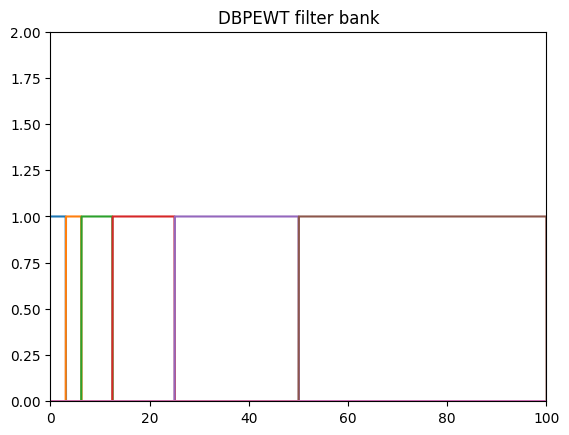

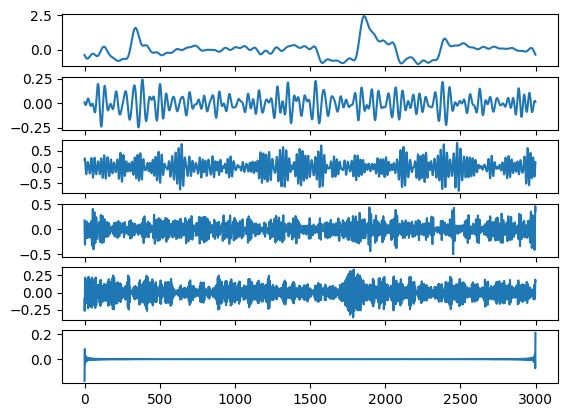

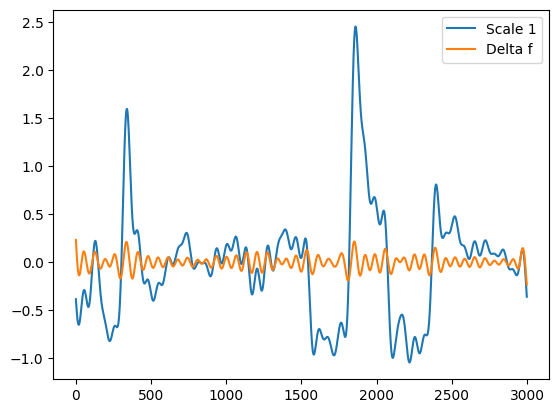

In [8]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from numpy.fft import fft, ifft

contaminated_data = sio.loadmat('contaminated.mat')

# Extract signals
x2 = contaminated_data['x2'].flatten()
Fs = 200
f = x2
N = len(f)

L = 6
frequency = Fs / (2 ** np.arange(L, 0, -1))
subresf = 1
boundaries = (frequency * (2 * np.pi)) / Fs

w1 = frequency[:-1]
w2 = frequency[1:]
gamma = (w2 - w1) / (w2 + w1)

# Compute FFT
ff = fft(f)

mfb = EWT_Meyer_FilterBank(boundaries, len(ff))

# Extract subbands
ewt = []
modes = np.zeros((len(mfb), N))
for k in range(len(mfb)):
    mm = np.real(ifft(np.conj(mfb[k]) * ff))
    ewt.append(mm)
    modes[k, :] = mm

# Plot filter bank
xxx = np.linspace(0, 1, len(mfb[0])) * Fs
plt.figure()
for i in range(len(mfb)):
    plt.plot(xxx, mfb[i])
plt.xlim([0, round(Fs / 2)])
plt.ylim([0, 2])
plt.title('DBPEWT filter bank')
plt.show()

# Placeholder function for boundary visualization
def Show_EWT_Boundaries(fft_f, boundaries, div, sampling_rate):
    pass # Implement boundary visualization if needed

Show_EWT_Boundaries(np.abs(fft(f)), boundaries, 1, Fs)

# Plot extracted scales
plt.figure()
for i in range(6):
    plt.subplot(6, 1, i + 1)
    plt.plot(ewt[i])
plt.show()

# Extract individual scales
scale1, scale2, scale3, scale4, scale5, scale6 = ewt[:6]

# Apply Savitzky-Golay filter
order = 2
alpha = 0.15
window = round(len(f) / (alpha * Fs))
if window % 2 == 0:
    window += 1
xsg = savgol_filter(scale1, window, order)

lam = 0.15
Nit = 50
xaf, cost = tvd_mm(xsg, lam, Nit)

deltaf = scale1 - xaf

plt.figure()
plt.plot(scale1, label='Scale 1')
plt.plot(deltaf, label='Delta f')
plt.legend()
plt.show()

receeg = deltaf + scale2 + scale3 + scale4 + scale5 + scale6


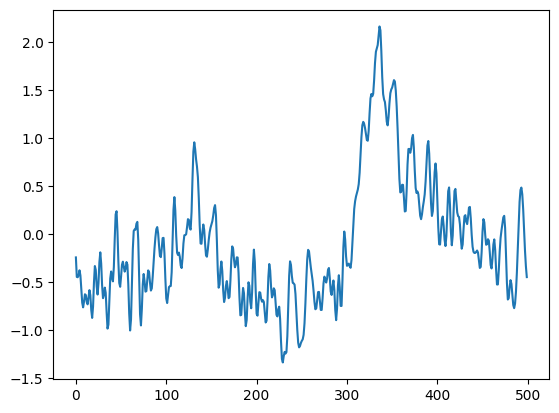

In [12]:
plt.plot(x2[0:500])

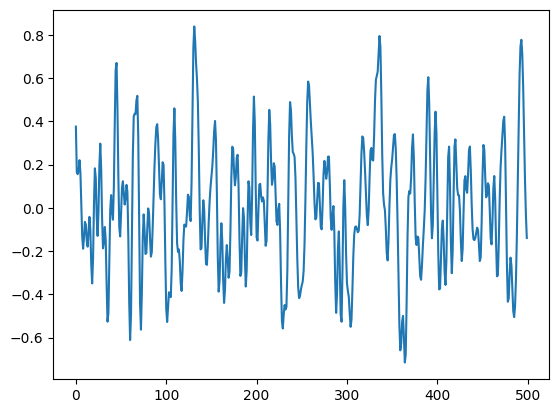

In [11]:
plt.plot(receeg[0:500])